In [1]:
import sys
import yaml
import torch
import logging
from pathlib import Path

# Add the path to the directory containing the omnicell package
# Assuming the omnicell package is in the parent directory of your notebook
sys.path.append('..')  # Adjust this path as needed

import yaml
import torch
import logging
from pathlib import Path
from omnicell.config.config import Config, ETLConfig, ModelConfig, DatasplitConfig, EvalConfig, EmbeddingConfig
from omnicell.data.loader import DataLoader
from omnicell.constants import PERT_KEY, GENE_EMBEDDING_KEY, CONTROL_PERT
from omnicell.data.catalogue import Catalogue
import numpy as np
import scanpy as sc
import scipy

In [2]:
dd = Catalogue.get_dataset_details('repogle_k562_essential_raw')
adata = sc.read(dd.path)

X = adata.X.toarray()



Observation Count Statistics:
  Minimum: 1782.0
  Maximum: 64082.0
  Mean:    13893.39
  Median:  13207.0
  Std:     5296.29

Feature Count Statistics:
  Minimum: 32762.0
  Maximum: 102889344.0
  Mean:    503596.94
  Median:  143572.0
  Std:     2420680.00


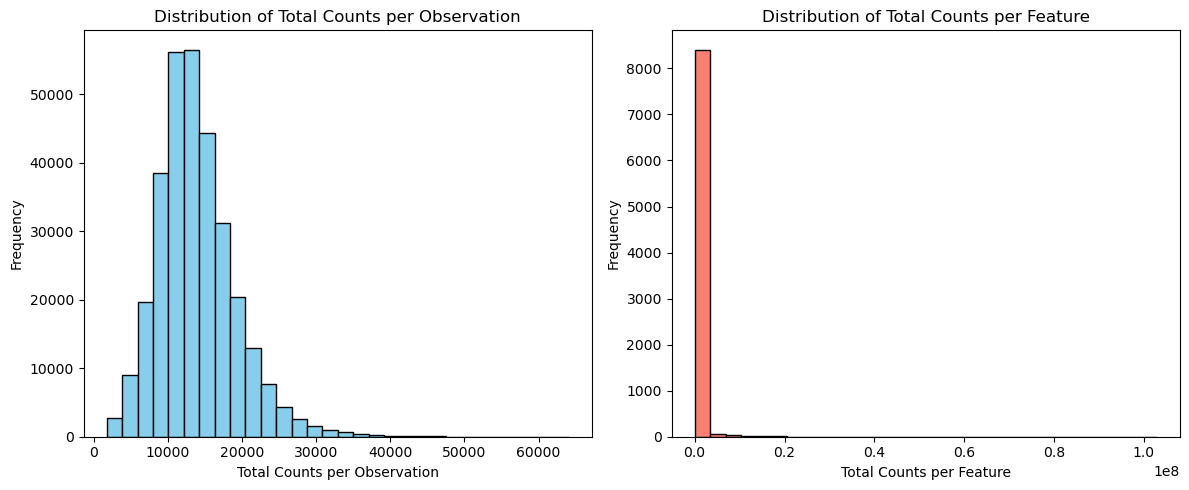

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# For demonstration purposes, let's assume X is a 2D numpy array with count data.
# You can replace this with your actual data.
# Example: 100 observations (rows) and 50 features (columns) with Poisson-distributed counts

# === Compute Count Statistics ===

# Total counts per observation (sum across features for each row)
obs_counts = X.sum(axis=1)
# Total counts per feature (sum across observations for each column)
feat_counts = X.sum(axis=0)

# Print observation count statistics
print("Observation Count Statistics:")
print(f"  Minimum: {np.min(obs_counts)}")
print(f"  Maximum: {np.max(obs_counts)}")
print(f"  Mean:    {np.mean(obs_counts):.2f}")
print(f"  Median:  {np.median(obs_counts)}")
print(f"  Std:     {np.std(obs_counts):.2f}")

print("\nFeature Count Statistics:")
print(f"  Minimum: {np.min(feat_counts)}")
print(f"  Maximum: {np.max(feat_counts)}")
print(f"  Mean:    {np.mean(feat_counts):.2f}")
print(f"  Median:  {np.median(feat_counts)}")
print(f"  Std:     {np.std(feat_counts):.2f}")

# === Plotting Histograms of the Count Distributions ===

plt.figure(figsize=(12, 5))

# Histogram for observation counts
plt.subplot(1, 2, 1)
plt.hist(obs_counts, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Total Counts per Observation")
plt.xlabel("Total Counts per Observation")
plt.ylabel("Frequency")

# Histogram for feature counts
plt.subplot(1, 2, 2)
plt.hist(feat_counts, bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Total Counts per Feature")
plt.xlabel("Total Counts per Feature")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [4]:
corr_matrix = np.corrcoef(X.T)


Shape of the correlation matrix: (8563, 8563)


Shape of PCA embeddings: (8563, 256)
Total variance explained: 0.962
Variance explained by top 10 components: [8.93538352e-01 1.81492257e-02 1.35792612e-02 7.13095665e-03
 6.42771536e-03 4.14080509e-03 2.98911813e-03 2.18333905e-03
 1.75593839e-03 7.98824123e-04]


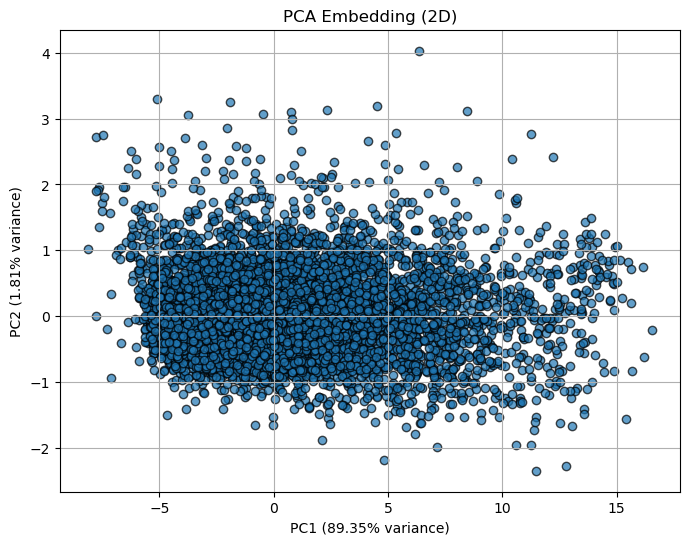

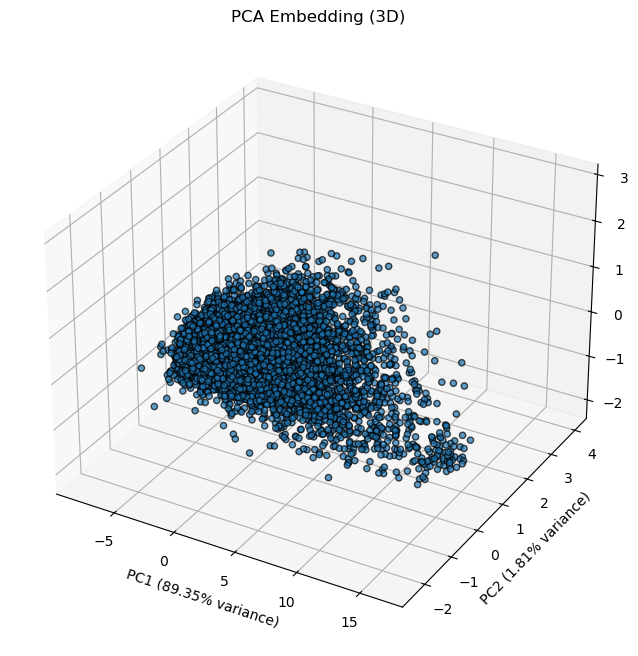

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from sklearn.decomposition import PCA

# === Step 1: Filter Out Observations with Too Low Counts ===
# Assume X is a NumPy array of shape (n_observations, n_features)

# === Step 2: Compute the Correlation Matrix Among Observations ===
# Since we are now focusing on the observations, we compute the correlation matrix along rows.
# Each entry (i, j) in this matrix represents the correlation between observation i and j.
print("Shape of the correlation matrix:", corr_matrix.shape)

# === Step 3: PCA on the Correlation Matrix ===
def generate_pca_embeddings(corr_matrix, n_components=256):
    """
    Generate PCA embeddings from a correlation matrix.
    
    Parameters:
    -----------
    corr_matrix : np.ndarray
        Input correlation matrix.
    n_components : int, default=256
        Number of PCA components to compute.
        
    Returns:
    --------
    embeddings : np.ndarray
        PCA embeddings with shape (n_observations_filtered, n_components)
    explained_variance_ratio : np.ndarray
        Proportion of variance explained by each component.
    """
    # Ensure the matrix is symmetric
    if not np.allclose(corr_matrix, corr_matrix.T):
        raise ValueError("Input matrix is not symmetric")
    
    # Initialize PCA; note that n_components cannot exceed the number of observations.
    pca = PCA(n_components=min(n_components, corr_matrix.shape[0]))
    
    # Fit PCA and transform the correlation matrix
    embeddings = pca.fit_transform(corr_matrix)
    
    return embeddings, pca.explained_variance_ratio_

# Compute PCA embeddings on the correlation matrix
pca_embeddings, variance_ratio = generate_pca_embeddings(corr_matrix)

# Print summary statistics
print(f"Shape of PCA embeddings: {pca_embeddings.shape}")
print(f"Total variance explained: {np.sum(variance_ratio):.3f}")
print(f"Variance explained by top 10 components: {variance_ratio[:10]}")

# === Step 4: Plot the PCA Embeddings ===
def plot_pca_embeddings(embeddings, variance_ratio):
    """
    Plot the PCA embeddings in 2D and 3D.
    
    Parameters:
    -----------
    embeddings : np.ndarray
        PCA embeddings with shape (n_observations_filtered, n_components)
    variance_ratio : np.ndarray
        Proportion of variance explained by each component.
    """
    # 2D Scatter Plot using the first two principal components
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.7, edgecolors='k')
    plt.xlabel(f'PC1 ({variance_ratio[0]*100:.2f}% variance)')
    plt.ylabel(f'PC2 ({variance_ratio[1]*100:.2f}% variance)')
    plt.title("PCA Embedding (2D)")
    plt.grid(True)
    plt.show()

    # 3D Scatter Plot using the first three principal components (if available)
    if embeddings.shape[1] >= 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], alpha=0.7, edgecolors='k')
        ax.set_xlabel(f'PC1 ({variance_ratio[0]*100:.2f}% variance)')
        ax.set_ylabel(f'PC2 ({variance_ratio[1]*100:.2f}% variance)')
        ax.set_zlabel(f'PC3 ({variance_ratio[2]*100:.2f}% variance)')
        ax.set_title("PCA Embedding (3D)")
        plt.show()

# Plot the embeddings
plot_pca_embeddings(pca_embeddings, variance_ratio)


In [6]:
pca_embeddings.shape

(8563, 256)

In [21]:
perts = [x for x in adata.obs[dd.pert_key].unique() if x != dd.control]


In [8]:
# Getting the index of each perturbation by looking at their index in the adata.var_names
np.where(adata.var_names == perts[6])


(array([], dtype=int64),)

In [9]:
indices

NameError: name 'indices' is not defined

In [22]:
perturbation_indices = [adata.var_names.get_loc(p) for p in perts if p in adata.var_names]

In [23]:
pca_embeddings[perturbation_indices].shape


(1868, 256)

In [17]:
len(perturbation_indices)

274482